In [2]:
#Step 0: Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [3]:
#Step 1: Load Data
#Serie de tiempo
df_raw = pd.read_csv("https://breathecode.herokuapp.com/asset/internal-link?id=2546&path=sales.csv")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [4]:
df_raw #En automático se ordena por los primeros y ultimos cinco

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
...,...,...
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214


In [5]:
#Step 2: Preprocessing
#Convertir ese mes y año en fecha
df_baking = df_raw.copy()
df_baking['date'] =  pd.to_datetime(df_baking['date'])
df_baking = df_baking.set_index('date')
df = df_baking.copy()
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2022-09-03 17:10:08.079328 to 2023-09-03 17:10:08.079328
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   366 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [6]:
#Step 3: EDA
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
sales,366.0,524.963968,275.089698,53.803211,290.186822,520.699468,763.289263,1000.482785


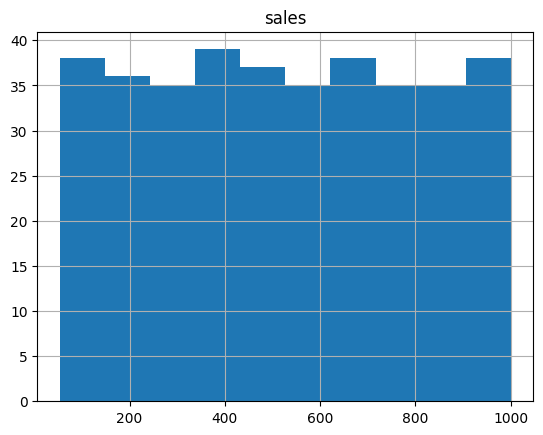

In [7]:
df.hist()
plt.show()

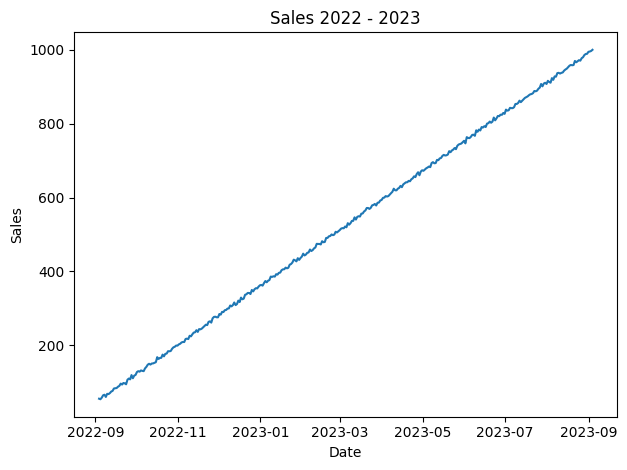

In [8]:
plt.plot(df)
plt.title("Sales 2022 - 2023")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

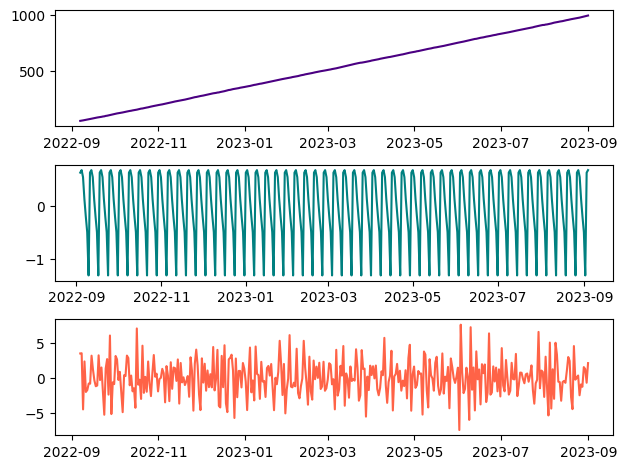

In [9]:
descomposition = seasonal_decompose(df)
trend = descomposition.trend
seasonal = descomposition.seasonal
residual = descomposition.resid

fig,ax= plt.subplots(3,1)
ax[0].plot(trend, c='indigo')
ax[1].plot(seasonal, c='teal')
ax[2].plot(residual, c='tomato')

plt.tight_layout()
plt.show()


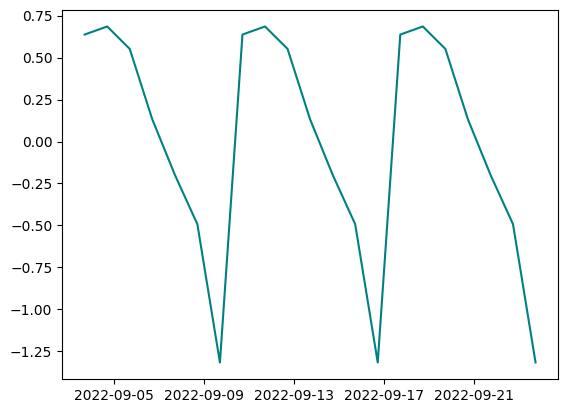

In [10]:
seasonal_head = seasonal.head(21)
plt.tight_layout()
plt.plot(seasonal_head, c='teal')
plt.show()

El tensor de la serie es de un   
Se aprecia una tendencia ascendente, lo que indica que las ventas han aumentado a lo largo del tiempo  
Se observa estacionalidad semanal
Se observa un ruido importante en la serie


In [11]:
df_1diff = df.diff(1).dropna()
test_dfuller= adfuller(df_1diff)
print(f'test Dickey_Fuller: {test_dfuller[0]:.2f}')
print(f'test p_value: {test_dfuller[1]:.2f}')

test Dickey_Fuller: -9.43
test p_value: 0.00


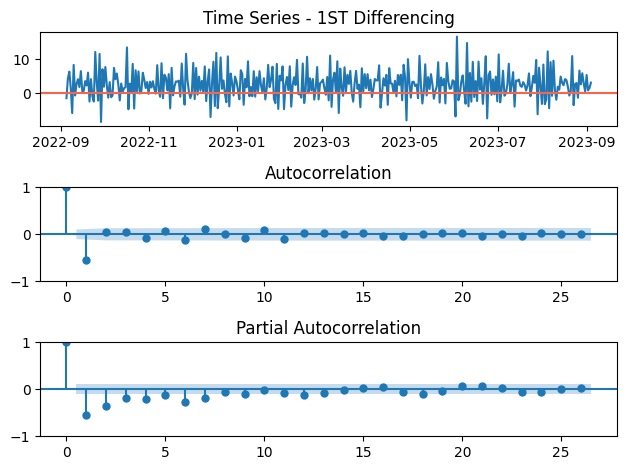

In [12]:
fig, ax =plt.subplots(3,1)
ax[0].plot(df_1diff)
ax[0].axhline(y=0,c='tomato')
ax[0].set_title('Time Series - 1ST Differencing')
plot_acf(df_1diff, ax=ax[1])
plot_pacf(df_1diff, ax=ax[2])
plt.tight_layout()
plt.show()

In [13]:
grid=[]
for p in range(3):
  for d in range(2):
    for q in range(2):
      for P in range(3):
        for D in range(3):
          for Q in range(3):
            temp_model = sm.tsa.SARIMAX(df,order=(p,d,q),seasonal_order=(P,D,Q,12),
                                        enforce_invertibility=False, enforce_stationarity=False)
            results=temp_model.fit()
            orders=f'{p}_{d}_{q}_{P}_{D}_{Q}'
            grid.append((orders, float(results.aic)))

/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization

In [14]:
sorted(grid, key=lambda x: x[1])[:5]

[('2_0_1_0_2_2', 1671.4438566998283),
 ('1_0_1_0_2_2', 1671.4683730116706),
 ('2_0_1_1_2_2', 1673.4438337809852),
 ('1_0_1_1_2_2', 1673.4683578645945),
 ('1_0_1_2_2_2', 1674.6378509406065)]

In [15]:
model=sm.tsa.SARIMAX(df, order=(2,0,1), seasonal_order=(0,2,2,7))
results=model.fit()
results.summary()

/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                  sales   No. Observations:                  366
Model:             SARIMAX(2, 0, 1)x(0, 2, [1, 2], 7)   Log Likelihood                -918.284
Date:                                Fri, 17 Oct 2025   AIC                           1848.569
Time:                                        00:02:04   BIC                           1871.750
Sample:                                    09-03-2022   HQIC                          1857.794
                                         - 09-03-2023                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8247      0.096      8.611      0.000       0.637       1.012
ar.L2          0.1182      0.053      2.246      0.025       0.015       0.221
ma.L1         -0.8895      0.082    -10.875      0.000      -1.050      -0.729
ma.S.L7       -1.9953      5.404     -0.369      0.712     -12.588       8.597
ma.S.L14       0.9968      5.385      0.185      0.853      -9.558      11.552
sigma2         8.4458     45.803      0.184      0.854     -81.326      98.217
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.06
Prob(Q):                              0.97   Prob(JB):                         0.59
Heteroskedasticity (H):               0.92   Skew:                             0.11
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
horizon = 24
forecast = results.get_forecast(horizon)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

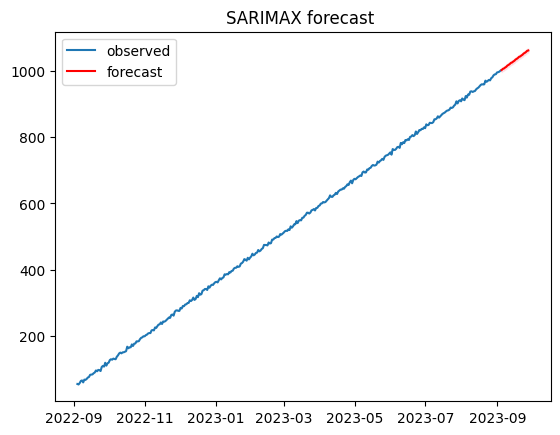

In [17]:
plt.plot(df, label="observed")
plt.plot(forecast_mean, c="r", label="forecast")
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color="pink", alpha=0.4)
plt.legend()
plt.title("SARIMAX forecast ")
plt.show()